In [54]:
import torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.optim import SGD

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

# Introduction:

Suppose we have the dataset $\vec x$ consisting of an independent and a dependent vector $x_i$ and $y_i$ ($i$ is the $i^\mathrm{th}$ value in the dataset). The goal of a Neural Network is as follows:

Define a function $f$ that depends on parameters $a_i$ that makes predictions as $$\hat y_i=f(x_i;a_i)$$ We want to make the predictions $\hat y_i$ and the true values $y_i$ as close as possible to the values of $a_i$, the methodology depends on the actual task. In general, we define a Similarity Function (or Loss Function) $L(y,\hat y)$. The more similar $y_i$ and $\hat y_i$ are, the smaller $L$ should be. This could be as simple as, for example: $$L(y,\hat y)=\sum_i(y_i-\hat y_i)^2$$

In [55]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

x, y

(tensor([[6., 2.],
         [5., 2.],
         [1., 3.],
         [7., 6.]]),
 tensor([1., 5., 2., 5.]))

We wanna find a function with parameters $a_i$ that lets us get from $x$ to $y$. The idea is to 
1. First multiply each element in $x$ by a 8 x 2 matrix (16 parameters $a_i$)
2. Then to the same, but by a 1 x 8 matrix this time (8 parameters $a_i$)

We'll hence define a matrix that takes in a 2d vector and returns an 8d vector:

In [56]:
M1 = nn.Linear(2, 8, bias = False)
M1

Linear(in_features=2, out_features=8, bias=False)

If we pass in the dataset $\vec x$ where each element (or instance) $x_i$ is a 2d vector. $M$ will apply the same matrix multiplication to each element $x_i$.

In [57]:
M1(x)

tensor([[-2.2607, -1.4337, -3.0233, -1.8528, -3.3092,  1.2012,  3.6561,  3.8370],
        [-1.9337, -1.2325, -2.6297, -1.7149, -2.7035,  0.9890,  3.2117,  3.2535],
        [-0.7752, -0.5415, -1.3863, -1.6761, -0.1185,  0.1042,  1.9287,  1.0880],
        [-3.1854, -2.0886, -4.7404, -4.0417, -3.2653,  1.2693,  6.0795,  5.0931]],
       grad_fn=<MmBackward0>)

In [30]:
M2 = nn.Linear(8, 1, bias = False)
M2

Linear(in_features=8, out_features=1, bias=False)

In [31]:
M2(M1(x))

tensor([[-1.4120],
        [-1.3025],
        [-1.2419],
        [-3.0314]], grad_fn=<MmBackward0>)

The weights of the matrices $M1$ and $M2$ constitute the weights of $a_i$ of the network defined above. In order to optimize for these weights, we first construct our network $f$ as follows:

In [58]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(2, 8, bias = False)
        self.Matrix2 = nn.Linear(8, 1, bias = False)

    def forward(self, x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)

        return x.squeeze()

Constructing the network using a subclass of the 'nn.Module' allows the network parameters to be conviniently stored. This'll be useful later, when we need to adjust them.

In [59]:
f = MyNeuralNetwork()

for par in f.parameters():
    print(par)

Parameter containing:
tensor([[-0.2955, -0.5988],
        [ 0.4554,  0.5453],
        [ 0.3827,  0.5578],
        [-0.6997,  0.1061],
        [-0.4237, -0.0187],
        [-0.5034, -0.2461],
        [ 0.2149, -0.0283],
        [-0.4476, -0.0657]], requires_grad=True)
Parameter containing:
tensor([[-0.3106,  0.3274,  0.2894, -0.3280,  0.2386,  0.1617, -0.2461, -0.0782]],
       requires_grad=True)


In [60]:
y_hat = f(x)
y_hat, y

(tensor([3.2026, 2.8219, 1.7579, 5.4196], grad_fn=<SqueezeBackward0>),
 tensor([1., 5., 2., 5.]))

# Adjusting $a_i$ so that $\hat y$ and $y$ are similar:

Now we'll define the Loss Function $L$, which provides a metric of similarity between $y$ and $\hat y$. In this case, we'll use the Mean Squared Error Loss Function:

In [61]:
L = nn.MSELoss()
L(y, y_hat)

tensor(2.4576, grad_fn=<MseLossBackward0>)

Just confirming that it's doing the same thing as the Regular Mean-Squared Error:

In [62]:
torch.mean((y - y_hat) ** 2)

tensor(2.4576, grad_fn=<MeanBackward0>)

Note that $L$ is a function of $a_i$ since our predictions $\hat y$ depend on the network parameters $a_i$. In this sense, $L=L(q)$. The main idea behind machine learning is to compute $$\frac{\partial L}{\partial a_i}$$ for each network parameter $a_i$. We then adjust each parameter as $$a_i\to a_i-\mathscr{l}\frac{\partial L}{\partial a_i}$$ where $\mathscr{l}$ is the Learning Rate.

We'll take an example of a Loss Function $L$ that depends only on one parameter $a$. Until we reach a minima for $L$, we'll repeat the aforementioned process again and again (what's called Gradient Descent). 

Each pass of the full dataset $\vec x$ is called an epoch. We're evaluating $\partial L/\partial a_i$ on the entire dataset $\vec x$ each time we iterate $a_i$ so each of those iterations corresponds to an epoch. 

The Stochastic Gradient Descent (or SGD) takes in all the model parameters $a_i$ along with the Learning Rate $\mathscr{l}$:

In [63]:
opt = SGD(f.parameters(), lr = 1e-03)

We adjust the parameters over and over:

In [64]:
losses = []

for _ in range(50):
    opt.zero_grad()
    
    loss_value = L(f(x), y)
    loss_value.backward()

    opt.step()
    losses.append(loss_value.item())

We'll now plot $L(a)$ as a function of the Number of Iterations:

Text(0, 0.5, 'Epochs')

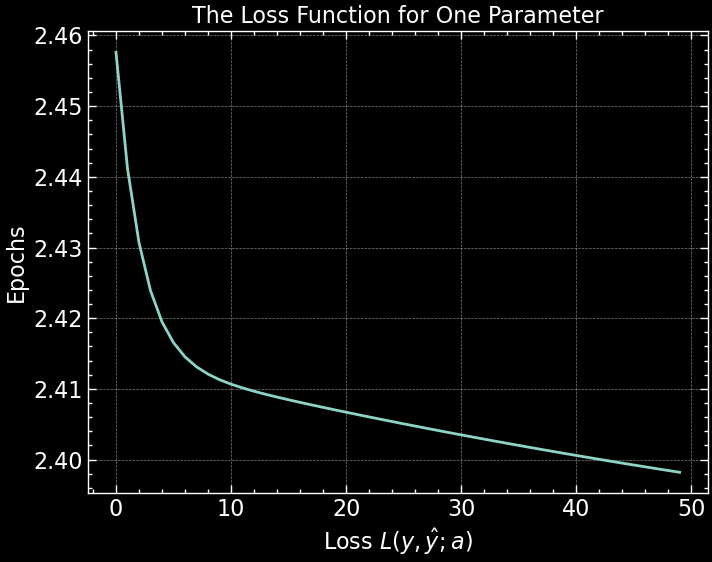

In [65]:
plt.plot(losses)

plt.title('The Loss Function for One Parameter')
plt.xlabel(r'Loss $L(y,\hat y;a)$')
plt.ylabel('Epochs')